# Trying to create a CIFAR 10 image prediction model

The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data.

In [1]:
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# includes
import torch
print(torch.cuda.is_available())
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

True


In [21]:
# saving and loading the model
def saveModel(model, path_name):
    torch.save(model.state_dict(), path_name)

def loadModel(model, path_name):
    model.load_state_dict(torch.load(path_name))

In [13]:
# loading data with only ToTensor to get the mean and std of the dataset for each channel
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=2)

# variables to store the sum and squared sum of pixel values for each channel
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)
num_batches = 0

for images, _ in train_loader:
    # sums of pixel values and squared pixel values for each channel
    channel_sum += images.mean(dim=[0, 2, 3]) # 0 - nr images, 1 - channels, 2 - height, 3 - width
    channel_squared_sum += (images ** 2).mean(dim=[0, 2, 3])
    num_batches += 1

# calculate the mean for each channel
mean = channel_sum / num_batches

# calculate the standard deviation for each channel
std = (channel_squared_sum / num_batches - mean ** 2).sqrt()

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4914, 0.4822, 0.4466])
Std: tensor([0.2470, 0.2435, 0.2616])


In [3]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, ), (0.5, ))
# ])

In [27]:
# "Data augmentation helps increase the diversity of your training data without actually collecting more data. By applying random transformations (like rotations, flips, and color changes), you can improve the model's ability to generalize."
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),  # randomly flip images horizontally
    # transforms.RandomRotation(15),  # randomly rotate images by up to 15 degrees
    # transforms.RandomCrop(32, padding=4),  # randomly crop and pad images
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # using the mean and std computed before
])

In [28]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True)

In [29]:
# model class
class C10ImageClassifier(nn.Module):
    def __init__(self):
        super(C10ImageClassifier, self).__init__()
        
        # 2 conv layers with 32 depth on output (+ pooling + dropout)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # conv layer with 3 channels, 32 filters, 3x3 and we do 1 pixel 0 padding around
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        
        # 2 conv layers with 64 depth on output (+ pooling + dropout)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        
        # 2 conv layers with 128 depth on output (+ pooling + dropout)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 4x4 after 3 pooling layers
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)  # 10 output classes for cifar10
        
    def forward(self, x):
        # conv => batch norm => relu => conv => batch => relu => pooling => dropout
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # flatten the images to prepare for the FC layers
        x = x.view(-1, 128 * 4 * 4)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

In [30]:
# model, optimizer and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda" if torch.cuda.is_available() else "cpu")

cifar10Model = C10ImageClassifier().to(device)
optimizer = optim.Adam(cifar10Model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

cuda


In [40]:
nrToLabel = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [31]:
# don't run this as it'll clear the losses and accuracies logged during training
train_losses = []
train_accuracies = []

In [32]:
# training the model
def trainModel(nrEpochs):
    for epoch in range(nrEpochs):
        cifar10Model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        # looping through the trainloader
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = cifar10Model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Compute accuracy (for plotting)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = correct_predictions / total_predictions
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f"Epoch [{epoch + 1}/{nrEpochs}], Loss: {epoch_loss}")

In [80]:
def testingSetAccuracy():
    cifar10Model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation to save memory and computation during evaluation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
            
            # Get model predictions
            outputs = cifar10Model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted labels
            
            # Update the number of correct predictions and total predictions
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    # Calculate accuracy
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

In [33]:
# plotting loss and accuracy
def plotLossAndAccuracy():
    plt.figure(figsize=(12, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [34]:
trainModel(25)

Epoch [1/25], Loss: 1.834333075761795
Epoch [2/25], Loss: 1.4255971627235413
Epoch [3/25], Loss: 1.222869842350483
Epoch [4/25], Loss: 1.0826842759251594
Epoch [5/25], Loss: 0.9771305139064789
Epoch [6/25], Loss: 0.8985828175842762
Epoch [7/25], Loss: 0.8218770017027854
Epoch [8/25], Loss: 0.7616251575648785
Epoch [9/25], Loss: 0.7056817167699337
Epoch [10/25], Loss: 0.6688921006023884
Epoch [11/25], Loss: 0.635539261162281
Epoch [12/25], Loss: 0.6063151877224445
Epoch [13/25], Loss: 0.5808384491801262
Epoch [14/25], Loss: 0.5627196142971516
Epoch [15/25], Loss: 0.5390376662611961
Epoch [16/25], Loss: 0.5211563555002212
Epoch [17/25], Loss: 0.505031967356801
Epoch [18/25], Loss: 0.49337846159934995
Epoch [19/25], Loss: 0.4723172733783722
Epoch [20/25], Loss: 0.4668542674928904
Epoch [21/25], Loss: 0.4485860938727856
Epoch [22/25], Loss: 0.44615750093758105
Epoch [23/25], Loss: 0.43163938687741754
Epoch [24/25], Loss: 0.4246846856325865
Epoch [25/25], Loss: 0.41735861733555796


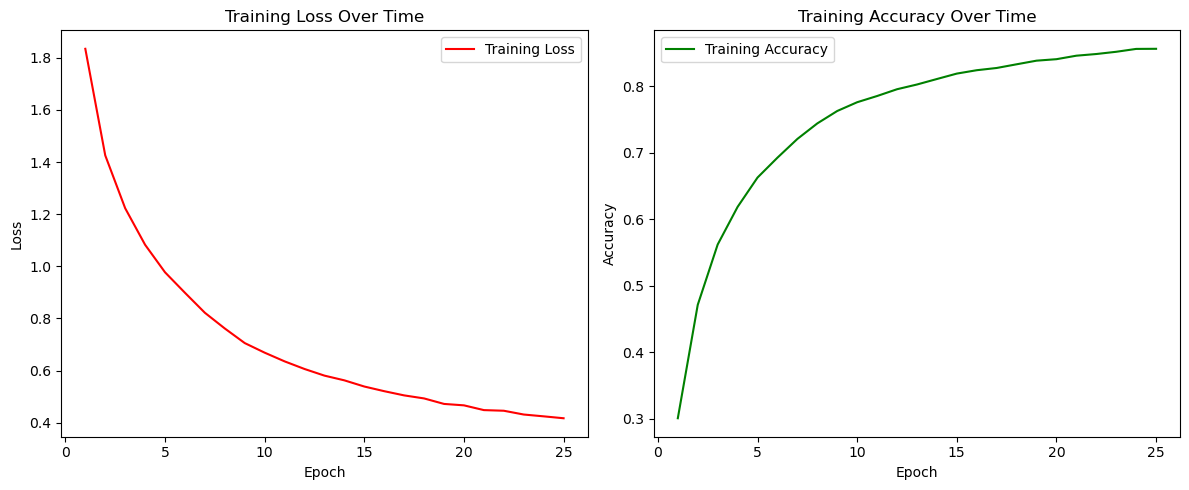

In [84]:
plotLossAndAccuracy() # the plot shown below is of the first 25 epochs

In [ ]:
# 85.17% accuracy at this point

In [85]:
trainModel(10)

Epoch [1/10], Loss: 0.41253842582553624
Epoch [2/10], Loss: 0.3992961799055338
Epoch [3/10], Loss: 0.3927997587546706
Epoch [4/10], Loss: 0.38800344190746544
Epoch [5/10], Loss: 0.3808014060929418
Epoch [6/10], Loss: 0.37321938775479796
Epoch [7/10], Loss: 0.3663495598882437
Epoch [8/10], Loss: 0.36344535844028
Epoch [9/10], Loss: 0.3570750315859914
Epoch [10/10], Loss: 0.348510327167809


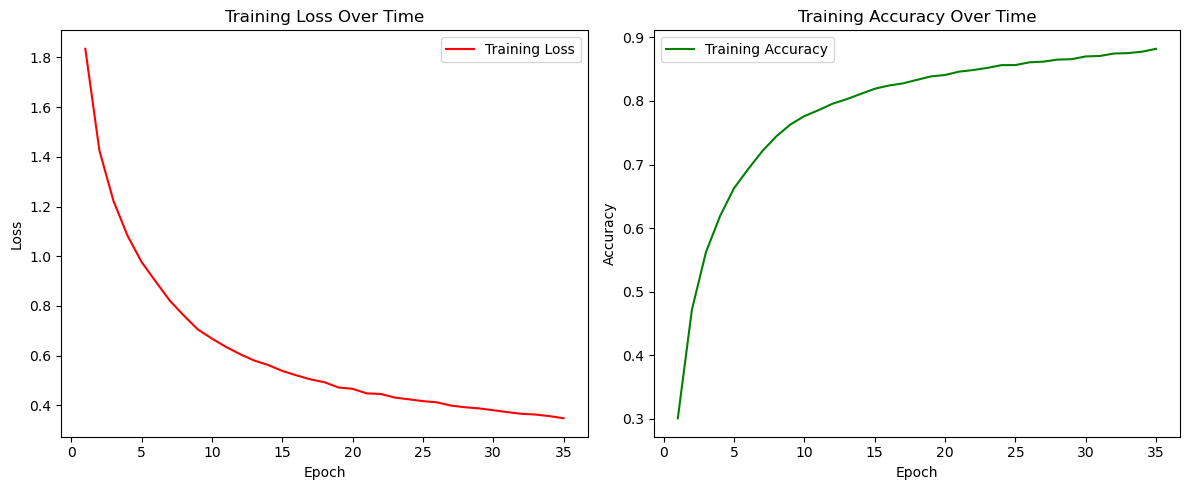

In [87]:
plotLossAndAccuracy() # the plot shown below is of the first 35 epochs

In [ ]:
# 85.77% accuracy at this point

In [88]:
# reducing learning rate by a factor of 10
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

In [89]:
trainModel(10)

Epoch [1/10], Loss: 0.29321455386653544
Epoch [2/10], Loss: 0.27312655045092105
Epoch [3/10], Loss: 0.2620024770796299
Epoch [4/10], Loss: 0.2574553060866892
Epoch [5/10], Loss: 0.2527828403562307
Epoch [6/10], Loss: 0.24583803298138082
Epoch [7/10], Loss: 0.24434581792727111
Epoch [8/10], Loss: 0.2386328364573419
Epoch [9/10], Loss: 0.2380260139517486
Epoch [10/10], Loss: 0.23628598585538566


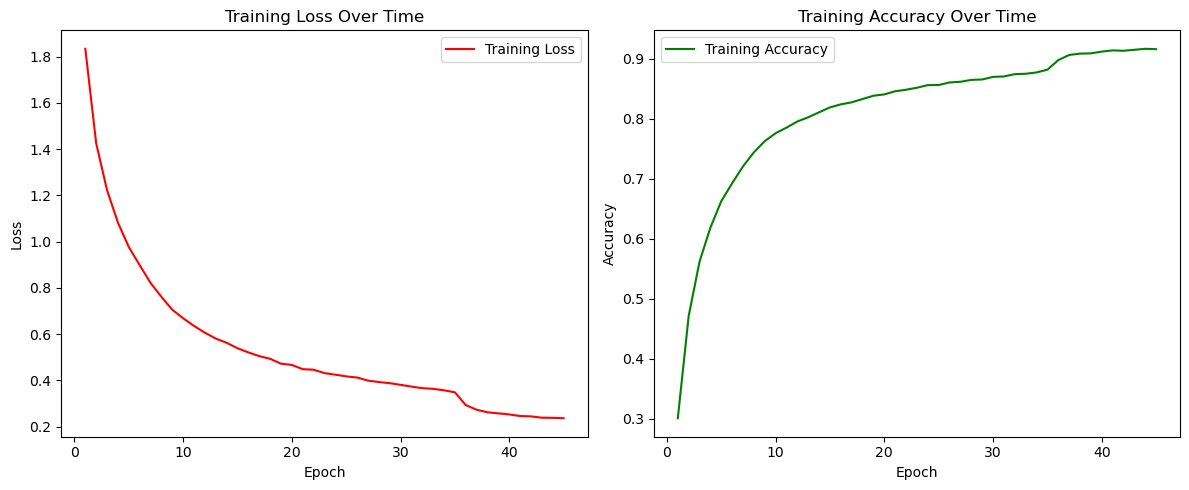

In [90]:
plotLossAndAccuracy() # the plot shown below is of the first 45 epochs

In [92]:
print(f"Accuracy: {testingSetAccuracy()}%")

Accuracy: 87.29%


In [93]:
# reducing learning rate again
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.5

In [94]:
trainModel(10)

Epoch [1/10], Loss: 0.23230526613071562
Epoch [2/10], Loss: 0.2243581322543323
Epoch [3/10], Loss: 0.22604892397858203
Epoch [4/10], Loss: 0.22431208162382246
Epoch [5/10], Loss: 0.22225627909973264
Epoch [6/10], Loss: 0.2223149123992771
Epoch [7/10], Loss: 0.22093819318898023
Epoch [8/10], Loss: 0.22066748006269335
Epoch [9/10], Loss: 0.21700221658218652
Epoch [10/10], Loss: 0.217332365475595


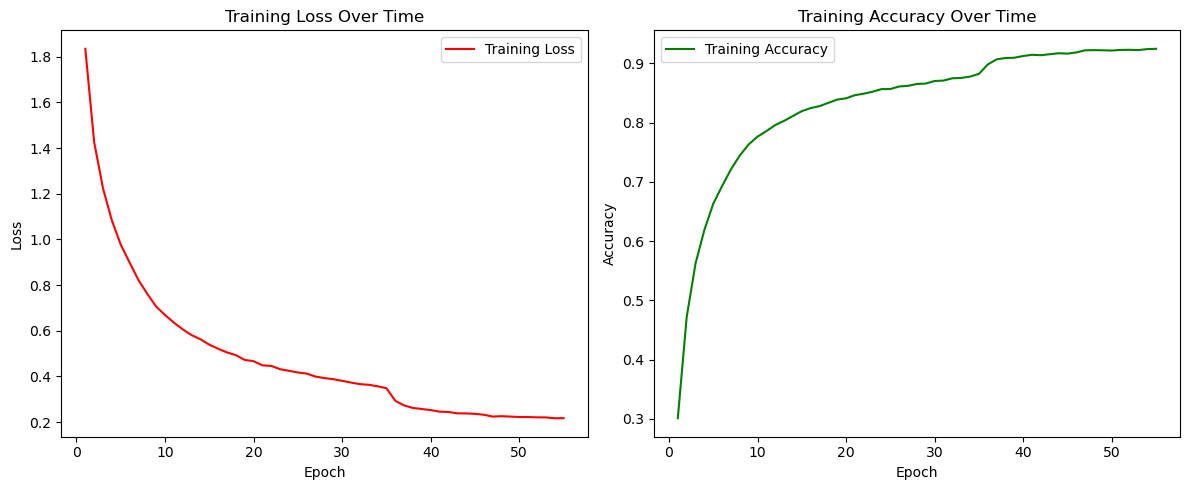

In [95]:
plotLossAndAccuracy() # the plot shown below is of the first 55 epochs

In [96]:
print(f"Accuracy: {testingSetAccuracy()}%")

Accuracy: 87.4%


In [97]:
# reducing learning rate again
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

In [98]:
trainModel(5)

Epoch [1/5], Loss: 0.21535372661799193
Epoch [2/5], Loss: 0.21491831588931382
Epoch [3/5], Loss: 0.21178867399692536
Epoch [4/5], Loss: 0.21012098084390163
Epoch [5/5], Loss: 0.21222462151013316


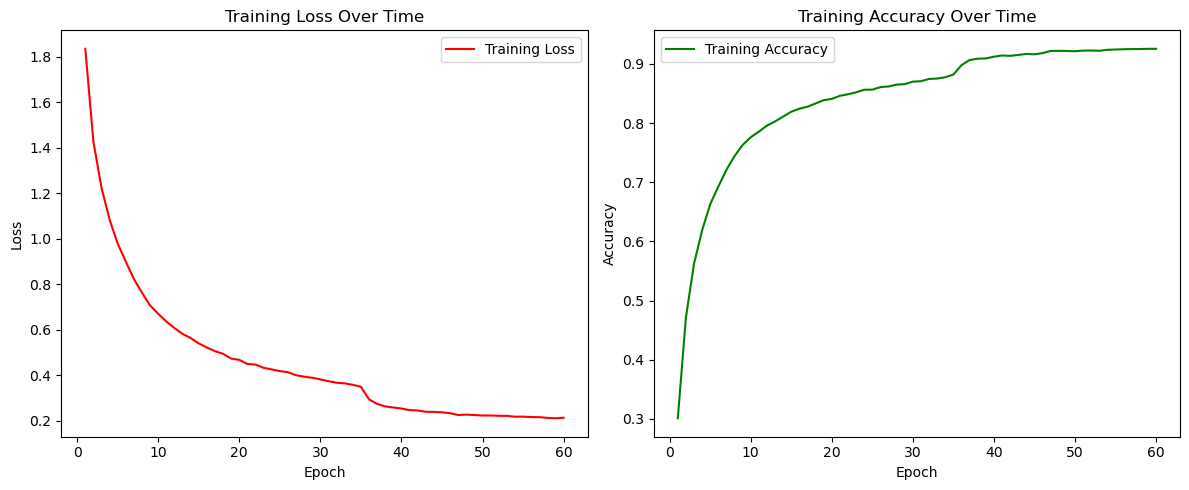

In [99]:
plotLossAndAccuracy() # the plot shown below is of the first 60 epochs

In [100]:
print(f"Accuracy: {testingSetAccuracy()}%")

Accuracy: 87.44%


In [55]:
imgMean = mean.view(3, 1, 1)
imgStd = std.view(3, 1, 1)
def imshow(img):
    img = img * imgStd + imgMean  # unnormalize the image
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor format to NumPy for displaying

def predictAndPlot(nrImages=5):
    cifar10Model.eval()  # set model to evaluation mode
    images, labels = next(iter(testloader))  # get a batch of test images
    images, labels = images[:nrImages], labels[:nrImages]  # limit to the first nrImages
    images, labels = images.to(device), labels.to(device)  # move data to the GPU if available

    # predict
    outputs = cifar10Model(images)
    _, predicted = torch.max(outputs, 1)  # get the predicted labels

    # plot the images with their predictions
    plt.figure(figsize=(12, 8))
    
    for i in range(nrImages):
        plt.subplot(1, nrImages, i + 1)
        imshow(images[i].cpu())  # move the image back to CPU for plotting
        plt.title(f"Predicted: {nrToLabel[predicted[i].item()]}\nLabel: {nrToLabel[labels[i].item()]}")
        plt.axis('off')
    
    plt.show()

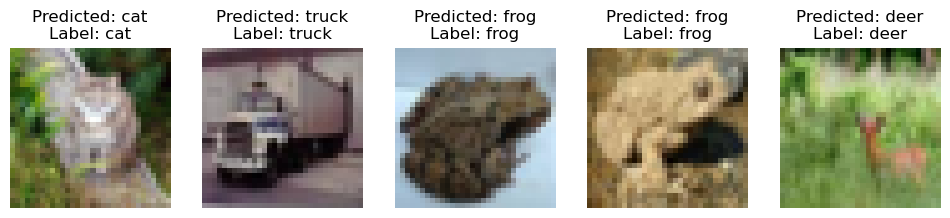

In [106]:
predictAndPlot(5)

In [101]:
saveModel(cifar10Model, "Accuracy87.44-60epochs.pth")

In [102]:
loadModel(cifar10Model, "CIFAR10Save.pth")